Takes in .AWD, sleep log if it exists, calendar, and spits out some pretty pictures

In [4]:
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, '/data/MoodGroup/actigraphy/gavi/actigraPy') 

import actigraPy.actigraPy as act
import importlib
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta

/data/MoodGroup/actigraphy/gavi/actigraPy/actigraPy/actigraPy.py:23: MatplotlibDeprecationWarning: 
The matplotlib.backends.tkagg module was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  import matplotlib.backends.tkagg as tkagg


## Subject and directory info

In [31]:
# data and log directories
sub = '135' #subject NUMBER as STRING
sub_long = 'sub-MOA'+sub

out_dir = '/data/MoodGroup/actigraphy/KMOA/derivatives/preproc/' + sub_long#output directory
data_dir = '/data/MoodGroup/actigraphy/KMOA/raw/' + sub_long

if not os.path.exists(out_dir):
    os.mkdir(out_dir)


In [33]:
fn = {}
#.AWD
awd_fn = os.path.join(data_dir, '%s_0.AWD'%sub_long)
#sleeplog
fn['cal']= os.path.join(data_dir, '%s_calendar_log.xls'%sub_long)
#calendar
fn['log'] = os.path.join(data_dir, '%s_sleeplog.xls'%sub_long)
logs = []

if os.path.isfile(awd_fn):
    for name in fn.keys():
        if os.path.isfile(fn[name]):
            print("%s has %s file at %s"%(sub,name,fn[name]))
            logs.append(fn[name])
        else:
            print("no " + name)
            fn[name] = ''
else:
    print("DO NOT CONTINUE!! THERE IS NO AWD FILE")

135 has cal file at /data/MoodGroup/actigraphy/KMOA/raw/sub-MOA135/sub-MOA135_calendar_log.xls
135 has log file at /data/MoodGroup/actigraphy/KMOA/raw/sub-MOA135/sub-MOA135_sleeplog.xls


In [34]:
awd_fn

'/data/MoodGroup/actigraphy/KMOA/raw/sub-MOA135/sub-MOA135_0.AWD'

### Make Mtimes file

Figure out where to clip awd file

In [35]:
#read AWD file
awd_dat = act.read_AWD(awd_fn)
idx={'start':[0],'end':[len(awd_dat['dt_list'])-1]}
#get the start and stops from each log if they exist
for log in logs:
    log_dat, kw_dat, comments = act.read_log(log,awd_dat)
    
    if 'watch_on' in kw_dat.keys():
        on_date = kw_dat['watch_on'].iloc[0]['OnDate']
        on_time = kw_dat['watch_on'].iloc[0]['OnTime']
        on = datetime(on_date.year,on_date.month,on_date.day,on_time.hour,on_time.minute)
        #check if that time is in dt_list:
        if awd_dat['dt_list'].count(on) > 0:
            on_idx=awd_dat['dt_list'].index(on)
            idx['start'].append(on_idx)

    if 'watch_off' in kw_dat.keys():
        off_date = kw_dat['watch_off'].iloc[0]['OffDate']
        off_time = kw_dat['watch_off'].iloc[0]['OffTime']
        off = datetime(off_date.year,off_date.month,off_date.day,off_time.hour,off_time.minute)
        if awd_dat['dt_list'].count(off) > 0:
            off_idx=awd_dat['dt_list'].index(off)
            idx['end'].append(off_idx)
 
idx

      OffDate   OffTime     OnDate    OnTime      Comment  Unnamed: 5  \
0         NaT       NaN 2016-02-08  10:00:00        start         NaN   
1  2016-02-08  13:00:00 2016-02-08  14:30:00           3T         NaN   
2  2016-02-08  21:30:00 2016-02-09  07:00:00  Sleep study         NaN   
3  2016-02-09  14:00:00 2016-02-09  16:00:00           7T         NaN   
4  2016-02-10  10:00:00 2016-02-10  12:00:00          MEG         NaN   
5  2016-02-10  21:30:00 2016-02-11  07:00:00  Sleep study         NaN   
6  2016-02-11  09:00:00 2016-02-11  09:40:00     Infusion         NaN   
7  2016-02-11  15:00:00 2016-02-11  17:00:00          MEG         NaN   
8  2016-02-11  21:30:00 2016-02-12  07:00:00  Sleep study         NaN   
9  2016-02-12  08:00:00 2016-02-12  10:00:00           7T         NaN   
10 2016-02-13  10:00:00 2016-02-13  11:30:00           3T         NaN   
11 2016-02-21  10:00:00 2016-02-21  12:00:00           7T         NaN   
12 2016-02-22  13:00:00 2016-02-22  14:30:00       

{'start': [0, 144], 'end': [45947, 45283, 44479]}

In [41]:
awd_dat['dt_list'][4750]

datetime.datetime(2016, 2, 11, 20, 26)

In [30]:
start = max(idx['start'])
end = min(idx['end'])
print('start = %d, end = %d'%(start,end))

start = 0, end = 59225


## <font color='red'>Make sure the starts and ends make sense before clipping the data</font>


In [17]:
#modify these according to output from above!!
lim = [awd_dat['DateTime'][start],awd_dat['DateTime'][end]]
clip_dat = act.clip_dat(lim,awd_dat)

Now just run these cells in order to extract comments and write Mtimes

In [18]:
importlib.reload(act)
#Make master mk_idx
mk_idx,comments=act.get_markers(clip_dat)

In [19]:
#Read logs
mc_dict = {} #for Mtimes
for name in fn.keys():
    if os.path.isfile(fn[name]):
        c_dict={}
        mk_idx_tmp,comments_tmp = act.get_markers(clip_dat,fn[name])
        mk_idx[name]=mk_idx_tmp['l']
        
        #process comments
        zipped_pairs = zip(comments_tmp[0].tolist(),comments_tmp[1])
        c_dict['comments'] = [x for _, x in sorted(zipped_pairs)]
        c_dict['idx'] = np.sort(comments_tmp[0])
        mc_dict[name]=c_dict

In [26]:
importlib.reload(act)
act.write_Mtimes_new(clip_dat,mk_idx,'sub-MOA'+sub,mc_dict)

,OffDate,OffTime,OnDate,OnTime,marker,Comment
0,17-Jan-12,11:03 AM,17-Jan-12,01:45 PM,z,
1,17-Jan-12,01:53 PM,17-Jan-12,02:33 PM,z,
2,17-Jan-12,09:09 PM,17-Jan-12,09:45 PM,z,
3,17-Jan-12,11:03 PM,18-Jan-12,06:37 AM,z,
4,18-Jan-12,06:57 AM,18-Jan-12,07:13 AM,z,
5,18-Jan-12,08:23 AM,18-Jan-12,08:47 AM,z,
6,18-Jan-12,10:35 AM,18-Jan-12,10:51 AM,z,
7,18-Jan-12,12:45 PM,18-Jan-12,02:29 PM,z,
8,18-Jan-12,03:57 PM,18-Jan-12,04:15 PM,z,
9,18-Jan-12,07:25 PM,18-Jan-12,07:45 PM,z,


In [27]:
act.write_dat(clip_dat,mk_idx,'/data/MoodGroup/actigraphy/KMOA/derivatives/preproc/subMOA-%s/%s'%(sub,sub))

,DateTime,activity,M,z
0,17-Jan-12 10:54 AM,818,,0
1,17-Jan-12 10:55 AM,507,,0
2,17-Jan-12 10:56 AM,461,,0
3,17-Jan-12 10:57 AM,178,,0
4,17-Jan-12 10:58 AM,53,,0
5,17-Jan-12 10:59 AM,323,,0
6,17-Jan-12 11:00 AM,392,,0
7,17-Jan-12 11:01 AM,476,,0
8,17-Jan-12 11:02 AM,2,,0
9,17-Jan-12 11:03 AM,0,,1


## Make graphs

In [57]:
coms=[]
idxs=[]
for mm in mc_dict.keys():
    print(mm)
    idxs= idxs +(mc_dict[mm]['idx'].tolist())
    coms= coms + (mc_dict[mm]['comments'])
zipped_pairs = zip(idxs,coms)
gc_coms = [x for _, x in sorted(zipped_pairs)]
gc_idx = np.sort(idxs)

gc=[np.asarray(gc_idx),gc_coms]

cal
log


In [58]:
gc

[array([  350,   542,  1325,  1340,  1905,  2540,  3095,  3230,  3920,
         4280,  4280,  4670,  5300,  5305,  5770,  6860,  6870, 11800,
        16375, 17150, 18380, 18950, 19110, 19990, 20000, 20510, 20600,
        21260, 22700, 23390, 24080, 24440, 24830, 26060, 26060, 27020,
        27850, 40160, 40670, 41655, 41660, 42860, 42860]),
 ['Sleep study',
  'shower',
  '7T MRI',
  '7T',
  'shower',
  'MEG',
  'shower',
  'Sleep study',
  'Infusion',
  'MEG',
  'MEG',
  'Sleep study',
  '7T',
  '7T MRI',
  'shower',
  '3T',
  '3TMRI',
  'shower',
  'shower',
  'shower',
  '7T',
  'shower end ???',
  'MRI',
  '3T end??',
  '3T',
  'Sleep study',
  'shower end??',
  '3T correct date??',
  'MEG',
  'Sleep study',
  'Infusion',
  'MEG',
  'Sleep study',
  '7T',
  '7T',
  '3T',
  'shower end??',
  '3T',
  'Sleep study',
  '7T',
  '7T',
  'MEG',
  'MEG']]

32
08-Feb-16
0 499
input 0 [-350]
plot this [-350, 499]
input 1 []
[0]
09-Feb-16
500 1939
input 0 [500, -500, 920]
plot this [-500, 500, -500, 920]
input 1 [-542, 580, -1325, 1495, -1905]
plot this [-542, 580, -1325, 1495, -1905, 1939]
[1 2 3 4]
10-Feb-16
1940 3379
input 0 [-2540, 2660, -3230]
plot this [-2540, 2660, -3230, 3379]
input 1 [1945, -3095, 3147]
plot this [-1940, 1945, -3095, 3147]
[5 6 7]
11-Feb-16
3380 4819
input 0 [3800, -3920, 3960, -4280, 4400, -4670]
plot this [-3380, 3800, -3920, 3960, -4280, 4400, -4670, 4819]
input 1 [-4280, 4400]
plot this [-4280, 4400]
[ 8  9 10 11]
12-Feb-16
4820 6259
input 0 [5240, -5300, 5420]
plot this [-4820, 5240, -5300, 5420]
input 1 [-5305, 5410, -5770, 5835]
plot this [-5305, 5410, -5770, 5835]
[12 13 14]
13-Feb-16
6260 7699
input 0 [-6860, 6950]
plot this [-6860, 6950]
input 1 [-6870, 6965]
plot this [-6870, 6965]
[15 16]
14-Feb-16
7700 9139
input 0 []
input 1 []
[]
15-Feb-16
9140 10579
input 0 []
input 1 []
[]
16-Feb-16
10580 12019
inp

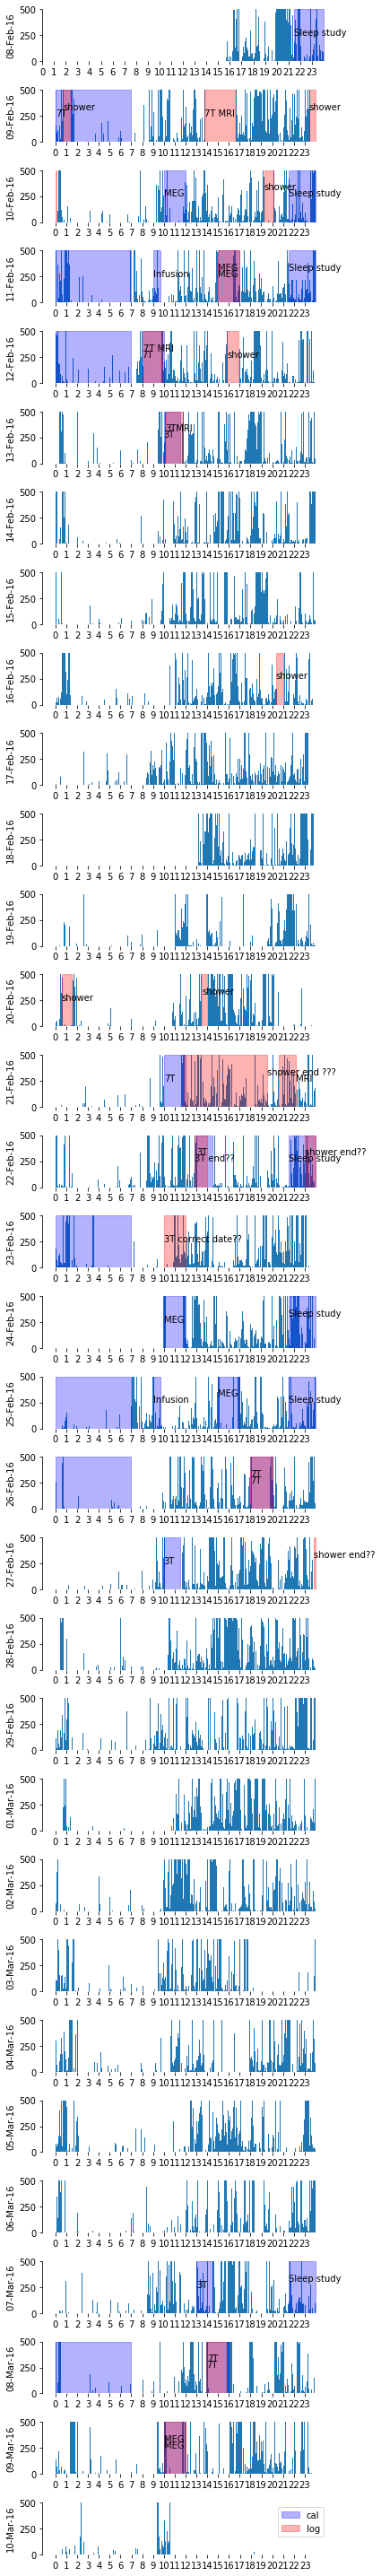

In [44]:
importlib.reload(act)

act.plot_awd(clip_dat,{'cal':mk_idx['cal'],'log':mk_idx['log']},max_act=500,show=False,comments=gc,fn_pref=os.path.join(out_dir,sub+'_M+logs'),plot_type='single',debug=True)


32
08-Feb-16
0 499
input 0 [-350]
plot this [-350, 499]
input 1 []
[0]
09-Feb-16
500 1939
input 0 [920, -1340, 1460]
plot this [-500, 920, -1340, 1460]
input 1 [-542, 580, -1325, 1495, -1905]
plot this [-542, 580, -1325, 1495, -1905, 1939]
[1 2 3 4]
10-Feb-16
1940 3379
input 0 [-2540, 2660, -3230]
plot this [-2540, 2660, -3230, 3379]
input 1 [1945, -3095, 3147]
plot this [-1940, 1945, -3095, 3147]
[5 6 7]
11-Feb-16
3380 4819
input 0 [3800, -3920, 3960, -4280, 4400, -4670]
plot this [-3380, 3800, -3920, 3960, -4280, 4400, -4670, 4819]
input 1 [-4280, 4400]
plot this [-4280, 4400]
[ 8  9 10 11]
12-Feb-16
4820 6259
input 0 [5240, -5300, 5420]
plot this [-4820, 5240, -5300, 5420]
input 1 [-5305, 5410, -5770, 5835]
plot this [-5305, 5410, -5770, 5835]
[12 13 14]
13-Feb-16
6260 7699
input 0 [-6860, 6950]
plot this [-6860, 6950]
input 1 [-6870, 6965]
plot this [-6870, 6965]
[15 16]
14-Feb-16
7700 9139
input 0 []
input 1 []
[]
15-Feb-16
9140 10579
input 0 []
input 1 []
[]
16-Feb-16
10580 12019

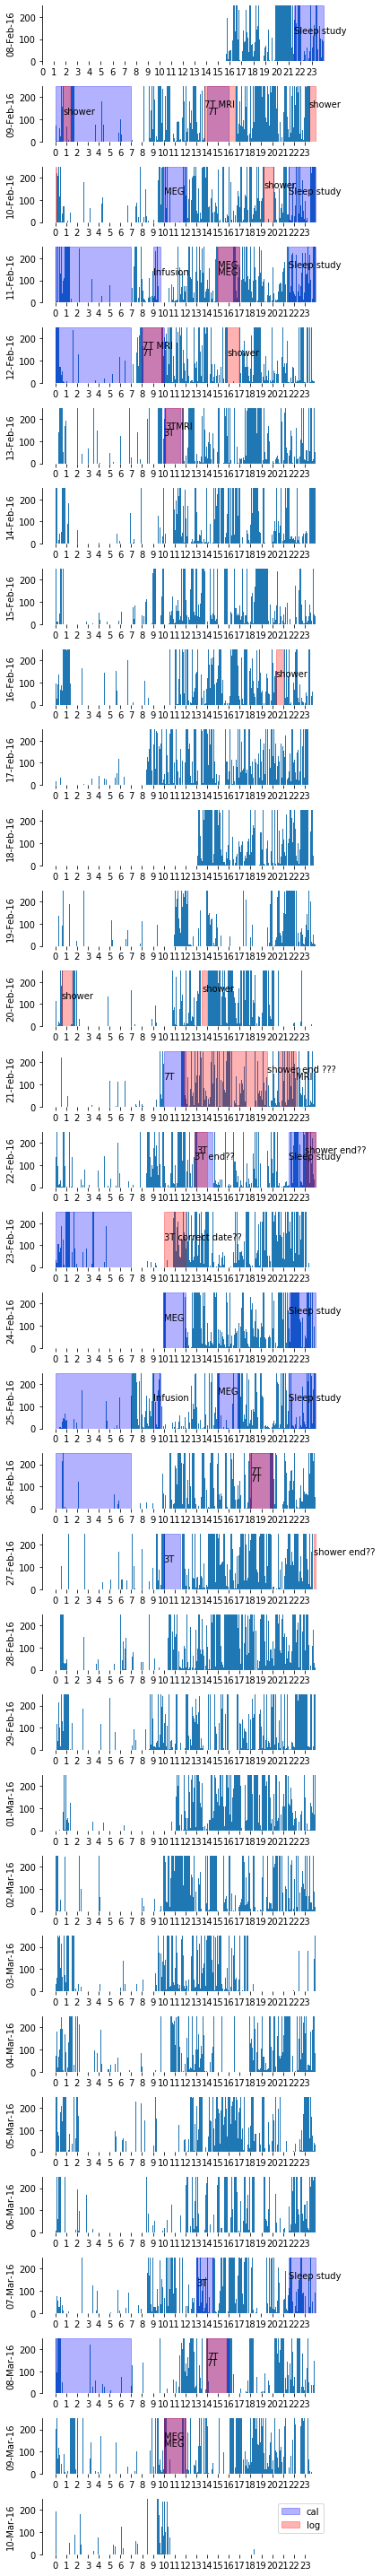

In [59]:
importlib.reload(act)

act.plot_awd(clip_dat,{'cal':mk_idx['cal'],'log':mk_idx['log']},max_act=250,show=False,comments=gc,fn_pref=os.path.join(out_dir,sub+'_M+logs_zoom'),plot_type='single',debug=True)


In [ ]:
      mm_dt = [ awd_dat['dt_list'][ii] for ii in mk_idx['m'] ]


In [ ]:
mm_dt

In [45]:
mk_idx['log']

array([  542,   580,  1325,  1495,  1905,  1945,  3095,  3147,  4280,
        4400,  5305,  5410,  5770,  5835,  6870,  6965, 11800, 11840,
       16375, 16430, 17150, 17180, 18485, 18950, 19015, 19110, 19990,
       20060, 20600, 20659, 21260, 21380, 26060, 26180, 27850, 27859,
       41655, 41765, 42860, 42980])

In [47]:
clip_dat['dt_list'][542]

Timestamp('2016-02-09 00:42:00')